In [2]:
# for loading/processing the images  
from tensorflow.keras.utils import load_img 
from tensorflow.keras.utils import img_to_array 
from keras.applications.vgg16 import preprocess_input 
from PIL import Image
from scipy.spatial import procrustes

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model
#from cellpose import models

# clustering and dimension reduction
from sklearn.cluster import AgglomerativeClustering
import hdbscan
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle
from natsort import natsorted, ns
import umap
from skimage.morphology import skeletonize,medial_axis,thin,rectangle
from skimage import img_as_bool, io, color, data, util
from skimage.transform import resize
import networkx as nx
import sknw
import gmatch4py as gm
import cv2

C:\Users\utilisateur\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\utilisateur\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\utilisateur\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
<frozen importlib._bootstrap>:228: UserWarning: To obtain optimal results install the Cython 'munkres' module at  https://github.com/jfrelinger/cython-munkres-wrapper


# Tentative d'hybridation des méthodes avec un tri par graphe dans chaque cluster par forme

In [3]:
path = '../rasters/parcelles_18e_reorientees'
# change the working directory to the path where the images are located
os.chdir(path)

# this list holds all the image filenames
parcelles = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.jpg'):
          # adds only the image files to the list
            parcelles.append(file.name)

In [4]:
#model = VGG16()

model = VGG16(
    include_top=True,
    weights="imagenet", #or "imagenet"
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000, #or 1000 for "imagenet"
    classifier_activation="softmax",
)
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

In [5]:
def extract_features(file):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

def extract_axes(file):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # Grayscale
    img = img.convert('L')
    # Threshold
    img = img.point( lambda p: 0 if p == 255 else 255 )
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # extract medial axis
    img = medial_axis(img, return_distance=False)
    img = img.astype(int)*255
    img = Image.fromarray(img, 'RGB')
    img = np.array(img)
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [6]:
def extract_complex_skeleton(parcelle):
    image = ~img_as_bool(color.rgb2gray(io.imread(parcelle)))
    ax = medial_axis(image).astype(np.uint16)
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    dilation = cv2.dilate(ax,kernel,iterations = 10)
    ske = skeletonize(dilation).astype(np.uint16)
    graph = sknw.build_sknw(ske)
    return(graph)

def extract_skeleton_image(parcelle):
    image = ~img_as_bool(color.rgb2gray(io.imread(parcelle)))
    ax = medial_axis(image).astype(np.uint16)
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    dilation = cv2.dilate(ax,kernel,iterations = 10)
    ske = skeletonize(dilation).astype(np.uint16)
    return(ske)

In [7]:
def extract_data(data,dataset,function):
    # lop through each image in the dataset
    for parcelle in dataset:
        # try to extract the features and update the dictionary
        try:
            feat = function(parcelle)
            data[parcelle] = feat
        # if something fails, save the extracted features as a pickle file (optional)
        except:
            pass

In [8]:
def extract_grouped_data(groups,dataset,labels):
    for file, cluster in zip(dataset,labels):
        if cluster not in groups.keys():
            groups[cluster] = []
            groups[cluster].append(file)
        else:
            groups[cluster].append(file)

In [9]:
def view_cluster(groups,cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 99:
        print(f"Clipping cluster size from {len(files)} to 99")
        files = files[:98]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

In [10]:
# function that lets you view a cluster (based on identifier)        
def view_cluster_graph(groups,graphs,cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 99:
        print(f"Clipping cluster size from {len(files)} to 99")
        files = files[:98]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        # draw edges by pts
        graph = graphs[file]
        for (s,e) in graph.edges():
            ps = graph[s][e]['pts']
            plt.plot(ps[:,1], ps[:,0], 'green')
    
        # draw node by o
        nodes = graph.nodes()
        ps = np.array([nodes[i]['o'] for i in nodes])
        plt.plot(ps[:,1], ps[:,0], 'r.')
        plt.axis('off')

In [11]:
data_full={}
extract_data(data_full,parcelles,extract_features)

1/1 [==============================] - 0s 245ms/step


HDBSCAN()

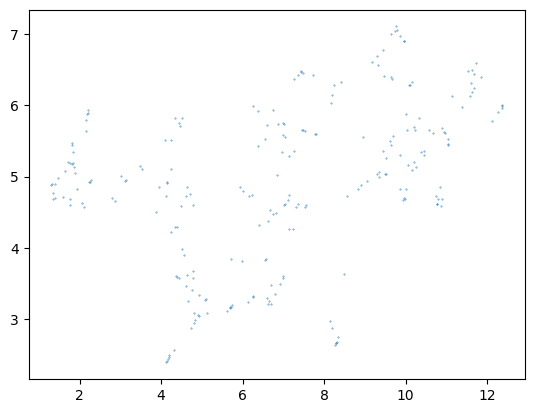

In [28]:
# get a list of the filenames
filenames = np.array(list(data_full.keys()))

# get a list of just the features
feat = np.array(list(data_full.values()))

# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)

# reduce the amount of dimensions in the feature vector
#pca = PCA(n_components=100, random_state=22)
#pca.fit(feat)
#x = pca.transform(feat)

#10, 0.1
x = umap.UMAP(
    n_neighbors=5,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(feat)

plt.scatter(x[:, 0], x[:, 1], s=0.1, cmap='Spectral');

# cluster feature vectors
#clustering = KMeans(n_clusters=len(unique_labels),n_jobs=-1, random_state=22)

#clustering = AgglomerativeClustering(n_clusters=40, linkage='complete')

clustering = hdbscan.HDBSCAN()

clustering.fit(x)

In [29]:
# holds the cluster id and the images { id: [images] }
groups_full = {}
extract_grouped_data(groups_full,filenames,clustering.labels_)

print(clustering.labels_)

[-1  9  9  9  9  9  9 -1 -1 -1 10 -1 10 10 10 12  5 12 10 10 10 10 -1 10
 10 10 12 10 10 10 -1 -1  5 12 12 12 12  2  2  2  2  2  2  1  1 -1  1  1
  1  1  1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1 -1 12 10 -1 -1  9 10  7  8  9  5 -1  5 -1  5 -1 -1  9 -1  6  6
  8  6 11 -1  6  5 10  4 10 10  5  5 10 10  9  5 10  7  6 -1  9  5 -1 12
  5  9  8  4  4 10 -1  4 10 10  4  4  4 11  3  3  3  3  3  8  8  3 -1  8
  8  6 10  8  7 -1 10 12  8  8  6  7 -1 11 -1  7 -1  8  8  6 10 -1 -1  7
 11 -1 -1 -1  7  8  6  8 -1 -1  8 -1 -1  7 -1  7 -1  0  0  0  0  0  0  0
  1  0  8 -1 10 10 10 10 10  8 11 10  6  8 11 11 -1 11 -1 -1 -1 11 10  8
  8  7  8 11 -1 -1 -1 11 10 -1 11  6 12 11 12 12  6  6  6 -1  6  6  6  6
 12  9 -1  1]


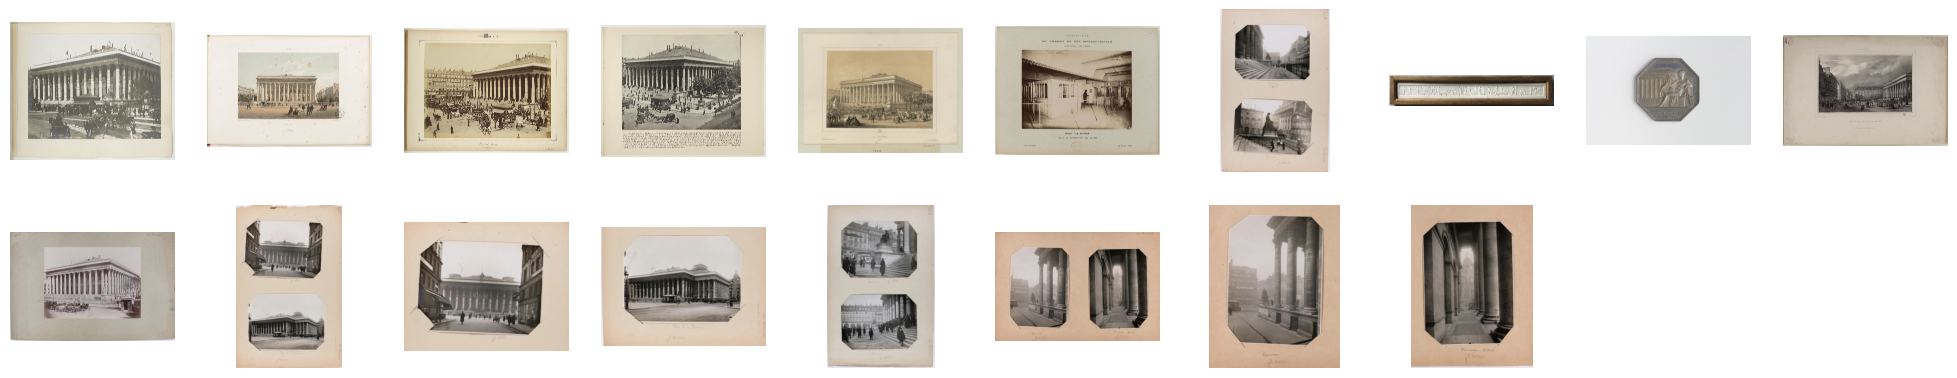

In [37]:
view_cluster(groups_full,6)

## Réalisation du tri secondaire

In [36]:
path = '../parcelles_18e_reorientees_graphes'
#change the working directory to the path where the images are located
os.chdir(path)

graphs_3={}
extract_data(graphs_3,groups_full[3],extract_complex_skeleton)

In [37]:
ged = gm.GraphEditDistance(1,1,1,0) # all edit costs are equal to 1
dist_mat = ged.compare(list(graphs_3.values()),None)

In [38]:
clustering = hdbscan.HDBSCAN(metric='precomputed')
#clustering = AgglomerativeClustering(n_clusters=10, metric='precomputed', linkage='complete')
clustering.fit(dist_mat)
print(clustering.labels_)

groups_3={}

extract_grouped_data(groups_3,np.array(list(graphs_3.keys())),clustering.labels_)

[ 0  0 -1  0  0  0  0 -1  1  1  1 -1 -1  1  1  1 -1  1 -1]


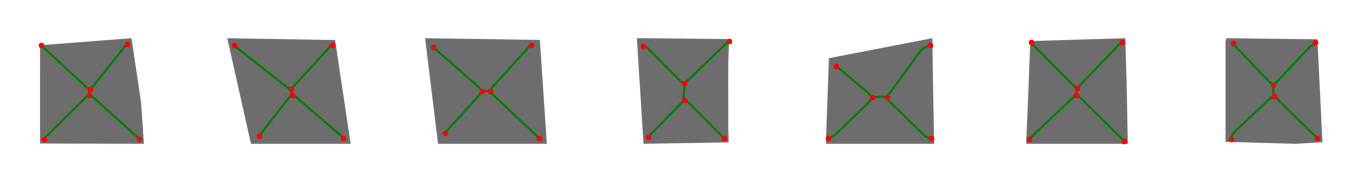

In [41]:
path = '../parcelles_18e_reorientees'
# change the working directory to the path where the images are located
os.chdir(path)

view_cluster_graph(groups_3,graphs_3,1)

In [224]:
from tqdm import tqdm

def pairwise_distance(axis_1,axis_2):
    mtx1, mtx2, disparity = procrustes(axis_1, axis_2)
    return(disparity)

axis = np.array(list(graphs_4.values()))
dim = len(axis)

pairwise_mat_axis = np.zeros((dim,dim))

for i in tqdm(range(0,dim)):
    for j in range(i+1,dim):
        try:
            dist = pairwise_distance(axis[i],axis[j])
            pairwise_mat_axis[i,j] = dist
            pairwise_mat_axis[j,i] = dist
        except:
            pairwise_mat_axis[i,j] = np.inf
            pairwise_mat_axis[j,i] = np.inf

100%|██████████████████████████████████████████████████████████████████████████████| 110/110 [2:07:09<00:00, 69.36s/it]


In [227]:
pairwise_mat_axis[pairwise_mat_axis == np.inf] = 100000.0

#clustering = hdbscan.HDBSCAN(metric='precomputed')
clustering = AgglomerativeClustering(n_clusters=20, metric='precomputed', linkage='complete')
clustering.fit(pairwise_mat_axis)
print(clustering.labels_)

groups_4={}

extract_grouped_data(groups_4,np.array(list(graphs_4.keys())),clustering.labels_)

[ 6  1  2  2  0  2  0 14  4 14  3  3  9 14  1 14  1  7  1  7  5 18  6  0
  1  4  7 11 19 12  1  0  9  4  1 10  9  7  0  7  0 19  2  1  8  8  2  9
 13  1  0 19  1 14 18  1 15 17  3  1  4 16  0  1  3  9  1  3  0  4 17  4
  5  2 17  2  1  2  8  2  5  2  8  3 17  0  7  5 17  2  4  4  9  8  5 17
  5  4  7 17  0 17 10  0 14  4  7  0  4  4]
